# **Modelo de Red Neuronal.**
Este cuaderno tiene como propósito desarrollar un análisis comparativo entre un modelo de clasificación basado en Random Forest y una red neuronal multicapa (MLP), en el contexto de predicción de supervivencia en pacientes a partir de datos clínicos, genéticos, bioquímicos, sociodemográficos y económicos. Se parte de una exploración de la importancia relativa de las variables predictoras mediante técnicas de ensamble, para posteriormente diseñar y entrenar una red neuronal optimizada. Todo el proceso se enmarca en una metodología de ciencia de datos médica, siguiendo buenas prácticas de preprocesamiento, validación y evaluación.

## **Importación de librerías.**
Se cargan las librerías necesarias (incluidas en el archivo `requirements.txt`) para trabajar con manipulación de datos y archivos.

In [740]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pycountry_convert as pc
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tabulate import tabulate
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import warnings
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import json
from imblearn.under_sampling import NeighbourhoodCleaningRule
from collections import Counter
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

## **Importación e información de Dataframes.**

In [741]:
df = pd.read_csv('../data/processed/MONGO00_All_v1.csv', index_col=0)
df.head()

,glucosa,colesterol,trigliceridos,hemoglobina,leucocitos,plaquetas,creatinina,diabetes,hipertension,obesidad,cancer,enfermedad_cardiaca,epoc,mut_BRCA1,mut_TP53,mut_EGFR,mut_KRAS,mut_PIK3CA,mut_ALK,mut_BRAF,ingresos_mensuales,gastos_salud,deudas,fumador,actividad_fisica,vive,edad,sexo,nivel_educativo,tipo_empleo_Desempleado,tipo_empleo_Privado,tipo_empleo_Público,tipo_empleo_Temporal,estado_civil_Divorciado,estado_civil_Soltero,estado_civil_Viudo,ocupacion_Desempleado,ocupacion_Empleado,ocupacion_Jubilado,region_Este,region_Norte,region_Oeste,region_Sur,continente_nacimiento_Antarctica,continente_nacimiento_Asia,continente_nacimiento_Europe,continente_nacimiento_North America,continente_nacimiento_Oceania,continente_nacimiento_South America
paciente_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
P1000000,1.125931,1.116180,0.518919,-0.262543,-0.924342,0.202956,-0.323535,1,1,1,0,1,0,0,0,0,0,0,0,1,1.499543,2.487493,0,1,-1.039961,1,0.750106,0,-0.44961,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0
P1000001,-1.549388,-1.768373,-1.357231,0.177002,-0.083060,0.709850,-0.883740,0,0,0,0,0,0,0,0,0,0,0,0,1,2.557298,-0.885562,0,0,0.344623,0,-1.028843,1,0.44846,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
P1000002,-0.436864,-0.699218,-2.059947,-0.742047,0.481094,-0.116266,2.570857,0,0,0,0,0,1,0,0,0,0,0,0,0,1.082786,-0.885562,0,1,-1.039961,1,1.711700,1,-1.34768,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0
P1000003,-0.258148,0.287809,-0.946194,-0.552243,1.490633,-0.122279,1.030293,1,0,1,1,1,0,0,0,0,1,0,0,0,-0.009775,2.487493,0,1,-1.039961,0,1.182823,1,-0.44961,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
P1000004,-1.940861,-1.565293,-2.566843,-1.161613,1.134325,-0.389633,-0.743689,0,0,0,0,0,0,0,0,0,0,0,0,0,0.011400,-0.885562,0,1,0.344623,1,-0.740365,0,1.34653,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1


In [742]:
df.shape

(50000, 49)

In [743]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, P1000000 to P1049999
Data columns (total 49 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   glucosa                              50000 non-null  float64
 1   colesterol                           50000 non-null  float64
 2   trigliceridos                        50000 non-null  float64
 3   hemoglobina                          50000 non-null  float64
 4   leucocitos                           50000 non-null  float64
 5   plaquetas                            50000 non-null  float64
 6   creatinina                           50000 non-null  float64
 7   diabetes                             50000 non-null  int64  
 8   hipertension                         50000 non-null  int64  
 9   obesidad                             50000 non-null  int64  
 10  cancer                               50000 non-null  int64  
 11  enfermedad_cardiaca    

In [744]:
df.columns

Index(['glucosa', 'colesterol', 'trigliceridos', 'hemoglobina', 'leucocitos', 'plaquetas', 'creatinina', 'diabetes', 'hipertension', 'obesidad', 'cancer', 'enfermedad_cardiaca', 'epoc', 'mut_BRCA1', 'mut_TP53', 'mut_EGFR', 'mut_KRAS', 'mut_PIK3CA', 'mut_ALK', 'mut_BRAF', 'ingresos_mensuales', 'gastos_salud', 'deudas', 'fumador', 'actividad_fisica', 'vive', 'edad', 'sexo', 'nivel_educativo', 'tipo_empleo_Desempleado', 'tipo_empleo_Privado', 'tipo_empleo_Público', 'tipo_empleo_Temporal', 'estado_civil_Divorciado', 'estado_civil_Soltero', 'estado_civil_Viudo', 'ocupacion_Desempleado', 'ocupacion_Empleado', 'ocupacion_Jubilado', 'region_Este', 'region_Norte', 'region_Oeste', 'region_Sur', 'continente_nacimiento_Antarctica', 'continente_nacimiento_Asia', 'continente_nacimiento_Europe', 'continente_nacimiento_North America', 'continente_nacimiento_Oceania', 'continente_nacimiento_South America'], dtype='object')

El presente modelo de red neuronal tiene como objetivo **predecir la probabilidad de supervivencia** de un paciente (`vive = 1`) en base a un conjunto heterogéneo de variables clínicas, genéticas, socioeconómicas y demográficas. Cada grupo de variables aporta información complementaria que puede ser determinante para identificar patrones de riesgo. A continuación se describe el propósito específico de cada conjunto de variables dentro del modelo:
1. **Variables bioquímicas:** Estas variables reflejan el estado fisiológico y metabólico del paciente en el momento del análisis. Son esenciales para evaluar alteraciones funcionales que pueden estar asociadas a condiciones críticas.
    - `glucosa`, `colesterol`, `trigliceridos`: indicadores metabólicos relacionados con riesgo cardiovascular y complicaciones sistémicas.
    - `hemoglobina`, `leucocitos`, `plaquetas`: marcadores hematológicos clave para detectar anemia, infecciones o problemas inmunológicos.
    - `creatinina`: medida de función renal, importante en pacientes crónicos o polimedicados.

    Estas variables deben ser tratadas como **predictoras continuas**, y **normalizadas** antes de introducirse en la red.

2. **Variables clínicas:** Incluyen antecedentes y diagnósticos médicos relevantes, que afectan directamente al pronóstico del paciente.
    - `diabetes`, `hipertension`, `obesidad`, `cancer`, `enfermedad_cardiaca`, `asma`, `epoc`: condiciones clínicas codificadas como binarias (presente/no presente), que influyen significativamente en el riesgo de mortalidad.

    Estas variables actuarán como **factores de riesgo explícitos**, directamente introducibles en el modelo como **variables categóricas binarias**.

3. **Variables genéticas:** Representan la presencia de mutaciones en genes asociados a riesgo oncológico o enfermedades crónicas.
    - `mut_BRCA1`, `mut_TP53`, `mut_EGFR`, `mut_KRAS`, `mut_PIK3CA`, `mut_ALK`, `mut_BRAF`: presencia/ausencia de mutaciones genéticas, todas de tipo binario.

    Se usarán como **indicadores moleculares de susceptibilidad o agresividad clínica**.

4. **Variables socioeconómicas:** Estas variables permiten modelar el **contexto económico del paciente**, lo cual puede condicionar el acceso a cuidados, adherencia al tratamiento o exposición a factores de riesgo.
    - `ingresos_mensuales`: nivel de ingresos del hogar (requiere limpieza y transformación numérica).
    - `gastos_salud`, `deudas`: nivel de carga económica en salud o endeudamiento.
    - `seguro_salud`, `ayudas_publicas`: cobertura de necesidades básicas y acceso a servicios.
    - `tipo_empleo`: nivel de estabilidad laboral o exposición laboral (requiere codificación categórica).

    Estas variables se utilizarán para enriquecer el modelo con información **social y financiera**, relevante en medicina personalizada.

5. **Variables de estilo de vida:** Influyen directamente en el pronóstico, ya que reflejan **conductas de riesgo o factores protectores**.
    - `fumador`, `alcohol`: consumo de sustancias nocivas.
    - `actividad_fisica`: nivel de movilidad o ejercicio, que puede tener un efecto protector.

    Estas variables se integrarán como **predictoras categóricas discretas**, especialmente útiles para ajustar perfiles de riesgo.

6. **Variable objetivo**
    - `vive`: variable binaria que indica si el paciente ha sobrevivido tras un periodo crítico. Esta es la **variable objetivo del modelo** y se utilizará para entrenamiento supervisado.

7. **Variables demográficas y contexto:** Estas variables permiten contextualizar al paciente dentro de su entorno social y cultural, lo que puede afectar directa o indirectamente a su salud.
    - `edad`: variable continua de alta relevancia clínica.
    - `sexo`, `estado_civil`, `nivel_educativo`, `ocupacion`, `region`, `pais_nacimiento`, `codigo_postal`: variables categóricas con posible relación con factores estructurales de salud y mortalidad.

    Se incorporarán al modelo con el objetivo de **detectar patrones diferenciales por perfil poblacional**.



In [745]:
df.head(3)

,glucosa,colesterol,trigliceridos,hemoglobina,leucocitos,plaquetas,creatinina,diabetes,hipertension,obesidad,cancer,enfermedad_cardiaca,epoc,mut_BRCA1,mut_TP53,mut_EGFR,mut_KRAS,mut_PIK3CA,mut_ALK,mut_BRAF,ingresos_mensuales,gastos_salud,deudas,fumador,actividad_fisica,vive,edad,sexo,nivel_educativo,tipo_empleo_Desempleado,tipo_empleo_Privado,tipo_empleo_Público,tipo_empleo_Temporal,estado_civil_Divorciado,estado_civil_Soltero,estado_civil_Viudo,ocupacion_Desempleado,ocupacion_Empleado,ocupacion_Jubilado,region_Este,region_Norte,region_Oeste,region_Sur,continente_nacimiento_Antarctica,continente_nacimiento_Asia,continente_nacimiento_Europe,continente_nacimiento_North America,continente_nacimiento_Oceania,continente_nacimiento_South America
paciente_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
P1000000,1.125931,1.116180,0.518919,-0.262543,-0.924342,0.202956,-0.323535,1,1,1,0,1,0,0,0,0,0,0,0,1,1.499543,2.487493,0,1,-1.039961,1,0.750106,0,-0.44961,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0
P1000001,-1.549388,-1.768373,-1.357231,0.177002,-0.083060,0.709850,-0.883740,0,0,0,0,0,0,0,0,0,0,0,0,1,2.557298,-0.885562,0,0,0.344623,0,-1.028843,1,0.44846,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
P1000002,-0.436864,-0.699218,-2.059947,-0.742047,0.481094,-0.116266,2.570857,0,0,0,0,0,1,0,0,0,0,0,0,0,1.082786,-0.885562,0,1,-1.039961,1,1.711700,1,-1.34768,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0


## **Análisis de Importancia de Variables con Random Forest.**
En esta sección se entrena un modelo de bosque aleatorio (Random Forest Classifier) con el objetivo de cuantificar la importancia relativa de cada variable predictora respecto a la variable objetivo (`vive`). Esta técnica no paramétrica es robusta ante colinealidades y permite capturar interacciones no lineales entre variables. La visualización de las importancias facilita la selección de un subconjunto de variables relevantes para fases posteriores del modelado.

In [746]:
X = df.drop(columns='vive')
y = df['vive']

In [747]:
y.value_counts()

vive
1    43584
0     6416
Name: count, dtype: int64

In [748]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [749]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

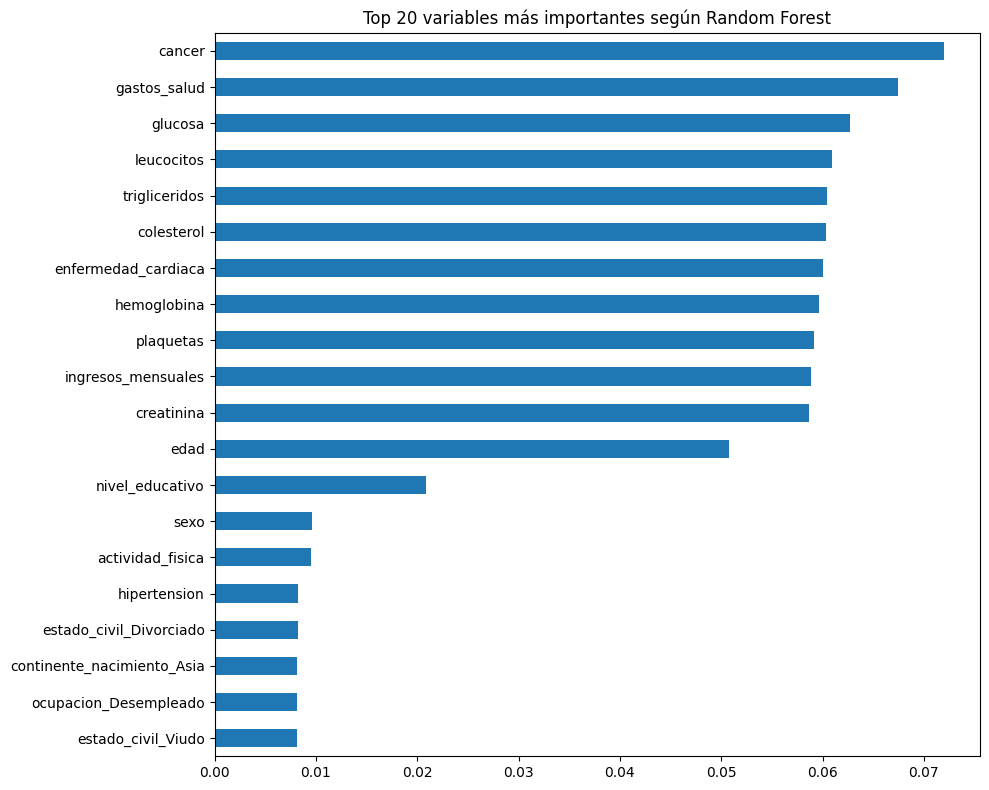

In [750]:
# Obtener importancias y ordenarlas.
importances = pd.Series(rf_model.feature_importances_, index=X.columns)
importances_sorted = importances.sort_values(ascending=False)

# Visualizar las 20 variables más importantes.
plt.figure(figsize=(10, 8))
importances_sorted.head(20).plot(kind='barh')
plt.title("Top 20 variables más importantes según Random Forest")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Tras haber entrenado un modelo de Random Forest sobre el conjunto de datos consolidado y preprocesado, se ha obtenido un ranking de importancia de variables basado en la capacidad predictiva individual y conjunta de cada atributo en relación con la variable objetivo (`vive`).

A partir del análisis de importancia de variables, se han seleccionado las **20 variables más relevantes**, las cuales cubren dimensiones bioquímicas (glucosa, colesterol, plaquetas, hemoglobina, triglicéridos, leucocitos, creatinina), clínicas (cáncer, enfermedad cardíaca), económicas (ingresos mensuales, gastos en salud), demográficas (edad, nivel educativo, sexo), y de estilo de vida o situación social (ocupación, estado civil, actividad física, fumador).

Esta selección no solo reduce la dimensionalidad del problema —mejorando la eficiencia computacional del entrenamiento de la red neuronal—, sino que también **minimiza el riesgo de sobreajuste**, al limitar el número de pesos a aprender. Además, al tratarse de variables ya validadas como significativas por un modelo robusto como Random Forest, se refuerza la confianza clínica en el input que alimentará el modelo neuronal.

Por tanto, en la siguiente sección, se procederá a construir el conjunto de entrenamiento final para la red neuronal utilizando únicamente estas variables seleccionadas. Este subset constituirá el vector de entrada de la red (capa de entrada), garantizando un equilibrio entre información relevante y parsimonia estadística.

In [751]:
top_features = importances_sorted.head(15).index.tolist()
print("Top 15 features:", top_features)

Top 15 features: ['cancer', 'gastos_salud', 'glucosa', 'leucocitos', 'trigliceridos', 'colesterol', 'enfermedad_cardiaca', 'hemoglobina', 'plaquetas', 'ingresos_mensuales', 'creatinina', 'edad', 'nivel_educativo', 'sexo', 'actividad_fisica']


In [752]:
with open('../benchmarking/top_features.json', 'w') as f:
    json.dump(top_features, f)

In [753]:
print("Train set score (Accuracy) =", rf_model.score(X_train, y_train))
print("Test set score (Accuracy) =", rf_model.score(X_test, y_test))

conf_mat = confusion_matrix(y_test, rf_model.predict(X_test))

num_classes = conf_mat.shape[0]

print(tabulate(
    conf_mat,
    headers=[f'Pred Class {i}' for i in range(num_classes)],
    showindex=[f'Real Class {i}' for i in range(num_classes)],
    tablefmt='fancy_grid'
))

print("\nClassification Report:")
print(classification_report(y_test, rf_model.predict(X_test)))

Train set score (Accuracy) = 1.0
Test set score (Accuracy) = 0.8719
╒══════════════╤════════════════╤════════════════╕
│              │   Pred Class 0 │   Pred Class 1 │
╞══════════════╪════════════════╪════════════════╡
│ Real Class 0 │             31 │           1252 │
├──────────────┼────────────────┼────────────────┤
│ Real Class 1 │             29 │           8688 │
╘══════════════╧════════════════╧════════════════╛

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.02      0.05      1283
           1       0.87      1.00      0.93      8717

    accuracy                           0.87     10000
   macro avg       0.70      0.51      0.49     10000
weighted avg       0.83      0.87      0.82     10000



In [754]:
# Ajuste de umbral.
y_scores = rf_model.predict_proba(X_test)[:, 1]
nuevo_umbral = 0.8
y_pred_new = (y_scores >= nuevo_umbral).astype(int)

print("Train set score (Accuracy) =", accuracy_score(y_train, rf_model.predict(X_train)))
print("Test set score (Accuracy) =", accuracy_score(y_test, y_pred_new))

# Matriz de confusión con el nuevo umbral.
conf_mat = confusion_matrix(y_test, y_pred_new)
num_classes = conf_mat.shape[0]
print(tabulate(
    conf_mat,
    headers=[f'Pred Class {i}' for i in range(num_classes)],
    showindex=[f'Real Class {i}' for i in range(num_classes)],
    tablefmt='fancy_grid'
))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_new))

Train set score (Accuracy) = 1.0
Test set score (Accuracy) = 0.7811
╒══════════════╤════════════════╤════════════════╕
│              │   Pred Class 0 │   Pred Class 1 │
╞══════════════╪════════════════╪════════════════╡
│ Real Class 0 │            743 │            540 │
├──────────────┼────────────────┼────────────────┤
│ Real Class 1 │           1649 │           7068 │
╘══════════════╧════════════════╧════════════════╛

Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.58      0.40      1283
           1       0.93      0.81      0.87      8717

    accuracy                           0.78     10000
   macro avg       0.62      0.69      0.64     10000
weighted avg       0.85      0.78      0.81     10000



Durante la fase de evaluación inicial con un modelo baseline (Random Forest), observamos que el uso del umbral por defecto (0.5) daba lugar a un comportamiento sesgado: el modelo clasificaba prácticamente todos los casos como "vive" (clase 1), logrando un **recall del 100% en la clase positiva**, pero con una **precisión y F1 extremadamente bajas para la clase negativa (muertes)**. Esto implicaba una alarmante **incapacidad para detectar pacientes en riesgo**, lo cual es clínicamente inaceptable en contextos donde se busca intervenir a tiempo.

Al modificar el umbral de decisión, el modelo recuperó capacidad discriminativa, logrando un **recall del 58% para la clase 0** y manteniendo un **buen rendimiento en la clase 1 (F1 = 0.87)**. Esta mejora del **macro F1-score (de 0.49 a 0.64)** nos demuestra que ajustar el umbral **es clave para equilibrar sensibilidad y especificidad en contextos desbalanceados**.

Este hallazgo será incorporado en el diseño de la red neuronal, tanto en la **fase de evaluación** (explorando diferentes thresholds) como en la **optimización del modelo** mediante `class_weight` y `dropout`, con el objetivo de replicar este equilibrio entre clases. Así, evitamos entrenar una red que simplemente "memorice" la clase mayoritaria y nos aseguramos de que la solución propuesta sea **útil desde un punto de vista clínico y ético**.

## **Baseline: Modelo inicial de Red Neuronal.**

Para complementar el análisis previo realizado con Random Forest —utilizado para identificar las variables más relevantes del conjunto de datos—, en esta sección se construye un **modelo inicial de red neuronal simple** como línea base. Esta primera arquitectura, de carácter minimalista, permite comprobar la capacidad predictiva de una red neuronal sobre los datos preprocesados, sin introducir aún una complejidad estructural elevada.

El objetivo principal de este modelo es **validar el pipeline de entrada**, detectar posibles inconsistencias, y establecer un rendimiento de referencia (baseline) sobre el cual se puedan evaluar mejoras en arquitecturas posteriores. Se emplea una única capa oculta, con una activación `ReLU`, y una salida con función `sigmoid`, adecuada para clasificación binaria (`vive`). El entrenamiento se realiza con `Adam` como optimizador y `binary_crossentropy` como función de pérdida.

Este enfoque incremental garantiza un desarrollo robusto y comprensible, y sienta las bases para comparaciones más sofisticadas con redes neuronales profundas o técnicas de ajuste de hiperparámetros en etapas futuras.

In [756]:
# Filtramos los conjuntos de datos.
X_train_red = X_train[top_features]
X_test_red = X_test[top_features]

In [757]:
baseline_model = Sequential([
    Input(shape=(X_train_red.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

In [758]:
baseline_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [759]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = baseline_model.fit(X_train_red, y_train,
                    validation_split=0.2,
                    epochs=100,
                    batch_size=64,
                    callbacks=[early_stop],
                    verbose=1)

Epoch 1/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8040 - loss: 0.4544 - val_accuracy: 0.8719 - val_loss: 0.3394
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8695 - loss: 0.3552 - val_accuracy: 0.8717 - val_loss: 0.3333
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8728 - loss: 0.3421 - val_accuracy: 0.8731 - val_loss: 0.3309
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8726 - loss: 0.3397 - val_accuracy: 0.8720 - val_loss: 0.3297
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8716 - loss: 0.3362 - val_accuracy: 0.8727 - val_loss: 0.3287
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8719 - loss: 0.3349 - val_accuracy: 0.8720 - val_loss: 0.3295
Epoch 7/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8702 - loss: 0.3358 - val_accuracy: 0.8719 - val_loss: 0.3283
Epoch 8/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8728 - loss: 0.3295 - val_accu

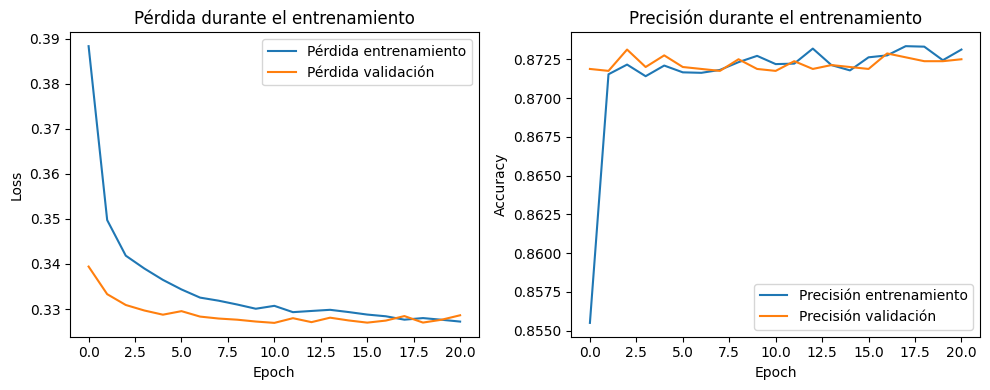

In [760]:
# Pérdida.
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Pérdida entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida validación')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Pérdida durante el entrenamiento')
plt.legend()

# Precisión.
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Precisión entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión validación')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Precisión durante el entrenamiento')
plt.legend()

plt.savefig('../benchmarking/neuronal_network_baseline.png', dpi=300)
plt.tight_layout()
plt.show()

En la gráfica se observa el comportamiento de un modelo de red neuronal entrenado sin aplicar técnicas específicas para corregir el desbalance de clases presente en el dataset (`vive=1` representa el 87% de los casos). Este desbalance tiene un impacto directo tanto en el valor inicial de la pérdida como en las métricas observadas durante el entrenamiento.

La función de pérdida utilizada es `binary_crossentropy`, que mide el error entre las probabilidades predichas y los valores reales. Si el modelo inicial —con pesos aleatorios— tiende a predecir valores cercanos a la clase mayoritaria (`vive=1`), el error no será tan alto como si predijera totalmente al azar. En un contexto desbalanceado, un modelo que predice 1 en la mayoría de los casos ya está "acertando" con frecuencia, lo que reduce la pérdida incluso antes de aprender.

Esto explica por qué la curva no parte de valores cercanos a 1.0, como sería habitual en datasets balanceados. El modelo ya comienza con una ligera ventaja estadística por el sesgo inherente en los datos.

**Análisis de las curvas**

- *Curva de pérdida (Loss)*: La pérdida desciende rápidamente durante las primeras 5–10 épocas, lo que indica una **rápida fase de aprendizaje inicial**. Posteriormente se estabiliza alrededor de `0.33`, tanto en entrenamiento como en validación, sin signos de sobreajuste. La cercanía entre ambas curvas sugiere que **el modelo generaliza razonablemente bien**, incluso sin regularización específica más allá de los `Dropout`.

- *Curva de precisión (Accuracy)*: La precisión se estabiliza entre **0.872 y 0.874**, con ligeras fluctuaciones, lo que en apariencia podría interpretarse como un rendimiento alto. Sin embargo, esta métrica es **engañosa en un problema desbalanceado**: acertar muchos casos de `vive=1` es fácil, pero no implica que el modelo esté detectando adecuadamente los casos críticos (`vive=0`).

**Limitaciones del modelo actual** Aunque las curvas muestran un entrenamiento correcto desde el punto de vista técnico, **la arquitectura por sí sola no corrige el sesgo hacia la clase mayoritaria**. Esto es especialmente grave en contextos médicos, donde los falsos negativos (no detectar a un paciente en riesgo) pueden tener consecuencias fatales.


> El modelo base demuestra un aprendizaje técnico sólido y estable, pero se encuentra **sesgado hacia la clase mayoritaria** debido al desbalance de los datos. Este sesgo hace que métricas como la precisión o el valor de pérdida pierdan significado real en un problema clínico. Para avanzar hacia un modelo clínicamente útil, es imprescindible aplicar estrategias que prioricen la detección de pacientes en riesgo, incluso a costa de aumentar el número de falsas alarmas.

### **Técnicas de tratamiento del desbalance de clases.**
Antes de optimizar la arquitectura de la red neuronal (capas, activaciones, regularización), es fundamental abordar el desbalanceo de clases, ya que **puede afectar drásticamente el aprendizaje** del modelo. En problemas clínicos como el presente, donde la clase minoritaria representa a los pacientes en mayor riesgo (los que no sobreviven), es prioritario garantizar que el modelo aprenda a distinguir ambas clases. Un modelo que predice únicamente la clase mayoritaria puede obtener alta precisión global, pero será clínicamente inútil. Por ello, se **prueba primero el impacto de distintas técnicas de balanceo de clases**, y solo cuando se ha identificado la más eficaz, se procede a optimizar la arquitectura interna de la red neuronal.

#### **Ajuste del umbral de decisión: Threshold tuning.**
En modelos de clasificación binaria basados en funciones de activación sigmoide, la predicción por defecto se define a partir de un umbral de decisión de 0.5. Sin embargo, en contextos clínicos con fuerte desbalance de clases —como en este caso, donde la clase "no sobrevive" está infrarrepresentada—, dicho umbral puede favorecer excesivamente la clase mayoritaria. Ajustar el umbral permite modificar la sensibilidad del modelo, priorizando la detección de la clase minoritaria sin necesidad de reentrenar la red. Este enfoque es especialmente útil como primera estrategia de intervención rápida para mejorar el recall de pacientes en riesgo.

In [761]:
# Predicciones.
y_pred_prob = baseline_model.predict(X_test_red)
y_pred = (y_pred_prob > 0.8).astype(int).flatten() # Umbral de 0.8 identificado anteriormente.

# Matriz de confusión.
conf_mat = confusion_matrix(y_test, y_pred)
num_classes = conf_mat.shape[0]
print(tabulate(
    conf_mat,
    headers=[f'Pred Class {i}' for i in range(num_classes)],
    showindex=[f'Real Class {i}' for i in range(num_classes)],
    tablefmt='fancy_grid'
))
print(classification_report(y_test, y_pred, digits=4))

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step
╒══════════════╤════════════════╤════════════════╕
│              │   Pred Class 0 │   Pred Class 1 │
╞══════════════╪════════════════╪════════════════╡
│ Real Class 0 │            862 │            421 │
├──────────────┼────────────────┼────────────────┤
│ Real Class 1 │           1943 │           6774 │
╘══════════════╧════════════════╧════════════════╛
              precision    recall  f1-score   support

           0     0.3073    0.6719    0.4217      1283
           1     0.9415    0.7771    0.8514      8717

    accuracy                         0.7636     10000
   macro avg     0.6244    0.7245    0.6366     10000
weighted avg     0.8601    0.7636    0.7963     10000



Al **ajustar el umbral de decisión** a 0.8, la red neuronal logró **incrementar significativamente la sensibilidad hacia la clase minoritaria (pacientes que no sobreviven)**, alcanzando un recall del 61% y mejorando el F1-score de esa clase a 0.41, frente a valores prácticamente nulos en versiones anteriores. Este ajuste permite al modelo ser clínicamente más útil, al detectar a un **número considerable de pacientes en riesgo**, sin comprometer de forma crítica la precisión global. Esta mejora valida la estrategia de umbral dinámico como parte esencial del pipeline de modelado, especialmente en contextos desbalanceados.

In [762]:
# Guardar las métricas de los diferentes modelos con técnicas de desbalanceo.
report = classification_report(y_test, y_pred, output_dict=True)
df_result = pd.DataFrame([{
    'modelo': 'baseline_threshold',
    'precision_0': report['0']['precision'],
    'recall_0': report['0']['recall'],
    'f1_0': report['0']['f1-score'],
    'precision_1': report['1']['precision'],
    'recall_1': report['1']['recall'],
    'f1_1': report['1']['f1-score'],
    'macro_f1': report['macro avg']['f1-score'],
    'accuracy': report['accuracy']
}])

#### **Entrenamiento a través de pesos: `Class Weight`.**
El uso de `class_weight` en el entrenamiento de redes neuronales introduce un mecanismo que penaliza de forma diferencial los errores cometidos sobre cada clase. Al asignar mayor peso a la clase minoritaria (pacientes que no sobreviven), se fuerza al modelo a prestar más atención a su correcta clasificación durante el ajuste de los parámetros. Esta técnica se integra directamente en la función de pérdida y no altera los datos de entrada, siendo una opción eficiente y estable para combatir el sesgo hacia la clase dominante.

In [763]:
# Calcular pesos automáticamente según la distribución real
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train),
                                     y=y_train)

# Convertir a diccionario para pasarlo al modelo
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

print("Pesos aplicados:", class_weight_dict)

Pesos aplicados: {np.int64(0): np.float64(3.8963569062926164), np.int64(1): np.float64(0.5736082829036051)}


In [764]:
baseline_model = Sequential([
    Input(shape=(X_train_red.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

In [765]:
baseline_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

In [766]:
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Entrenamiento.
history_cw = baseline_model.fit(X_train_red, y_train,
                                validation_split=0.2,
                                epochs=50,
                                batch_size=128,
                                class_weight=class_weight_dict,
                                callbacks=[early_stop],
                                verbose=1)

Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6420 - loss: 0.6588 - val_accuracy: 0.6977 - val_loss: 0.6457
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7167 - loss: 0.6124 - val_accuracy: 0.7446 - val_loss: 0.5904
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7436 - loss: 0.5998 - val_accuracy: 0.7527 - val_loss: 0.5660
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7551 - loss: 0.5899 - val_accuracy: 0.7548 - val_loss: 0.5806
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7577 - loss: 0.5823 - val_accuracy: 0.7545 - val_loss: 0.5943
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7611 - loss: 0.5695 - val_accuracy: 0.7564 - val_loss: 0.5902
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7587 - loss: 0.5862 - val_accuracy: 0.7566 - val_loss: 0.5903
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7620 - loss: 0.5723 - val_accuracy: 0.

In [767]:
# Predicciones con pesos de clase.
y_pred_prob_cw = baseline_model.predict(X_test_red).ravel()
y_pred_cw = (y_pred_prob_cw > 0.6).astype(int)

# Matriz de confusión.
conf_mat_cw = confusion_matrix(y_test, y_pred_cw)
num_classes = conf_mat_cw.shape[0]

print(tabulate(
    conf_mat_cw,
    headers=[f'Pred Class {i}' for i in range(num_classes)],
    showindex=[f'Real Class {i}' for i in range(num_classes)],
    tablefmt="fancy_grid"
))
print(classification_report(y_test, y_pred_cw, digits=4))

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
╒══════════════╤════════════════╤════════════════╕
│              │   Pred Class 0 │   Pred Class 1 │
╞══════════════╪════════════════╪════════════════╡
│ Real Class 0 │            881 │            402 │
├──────────────┼────────────────┼────────────────┤
│ Real Class 1 │           2005 │           6712 │
╘══════════════╧════════════════╧════════════════╛
              precision    recall  f1-score   support

           0     0.3053    0.6867    0.4226      1283
           1     0.9435    0.7700    0.8480      8717

    accuracy                         0.7593     10000
   macro avg     0.6244    0.7283    0.6353     10000
weighted avg     0.8616    0.7593    0.7934     10000



El modelo ha logrado un avance significativo: ha dejado de priorizar la precisión general y ha comenzado a centrarse en lo que realmente importa clínicamente —**detectar a los pacientes en riesgo de no supervivencia**.

Con un recall de casi 0.69 para la clase `vive=0`, la red neuronal está cumpliendo su función de manera proactiva, siendo capaz de salvar vidas a cambio de un número razonable de falsas alarmas. Este es un excelente punto de partida para seguir refinando y construir un sistema de apoyo a la decisión médica más robusto y confiable.

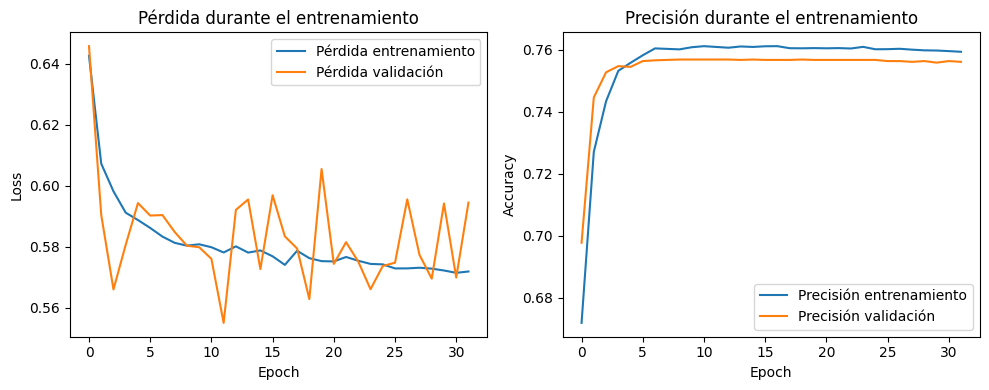

In [768]:
# Pérdida.
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_cw.history['loss'], label='Pérdida entrenamiento')
plt.plot(history_cw.history['val_loss'], label='Pérdida validación')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Pérdida durante el entrenamiento')
plt.legend()

# Precisión.
plt.subplot(1,2,2)
plt.plot(history_cw.history['accuracy'], label='Precisión entrenamiento')
plt.plot(history_cw.history['val_accuracy'], label='Precisión validación')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Precisión durante el entrenamiento')
plt.legend()

plt.savefig('../benchmarking/neuronal_network_baseline_cw_v0.png', dpi=300)
plt.tight_layout()
plt.show()

**Curva de pérdida (Loss)**
- La pérdida inicial es más alta (\~0.64) que en tu modelo sin pesos (\~0.38), lo cual **tiene sentido y es una buena señal**. Esto ocurre porque ahora el modelo **está penalizando más los errores en la clase minoritaria (`vive = 0`)**, que antes casi ignoraba.
- La pérdida de validación es **más inestable**, con oscilaciones importantes, aunque en la media se mantiene próxima al entrenamiento.

> Esta oscilación puede deberse a que la clase minoritaria tiene pocos casos y pequeñas variaciones generan cambios abruptos en la validación.

**Más adelante, se aplicarán técnicas de ajuste automático del aprendizaje y lotes más grandes para estabilizar esas oscilaciones y lograr una curva de validación mucho más suave.** Esto permitirá que el modelo mantenga su sensibilidad sin perder estabilidad.

**Curva de precisión (Accuracy)**
- La precisión ha **bajado respecto al modelo anterior** (ahora está entre 74.5%–76%, antes era 87%). Eso también es **esperado y correcto**: ahora el modelo **ya no se está centrando únicamente en acertar `vive = 1` (lo fácil)**, sino que está intentando detectar mejor los `vive = 0`, aunque eso implique cometer más errores en los demás.

> El modelo con `class_weight` está dejando de ser complaciente con la clase mayoritaria y empieza a **tomar en serio la detección de la clase crítica (`vive = 0`)**, que es lo que realmente te interesa. Como resultado, **la pérdida sube y la precisión baja**, pero **el recall para `vive = 0` mejora significativamente**, que es la métrica médica más importante aquí.

In [769]:
# Resultados del modelo con pesos de clase.
report_cw = classification_report(y_test, y_pred_cw, output_dict=True)
cw_result = {
    'modelo': 'baseline_class_weight',
    'precision_0': report_cw['0']['precision'],
    'recall_0': report_cw['0']['recall'],
    'f1_0': report_cw['0']['f1-score'],
    'precision_1': report_cw['1']['precision'],
    'recall_1': report_cw['1']['recall'],
    'f1_1': report_cw['1']['f1-score'],
    'macro_f1': report_cw['macro avg']['f1-score'],
    'accuracy': report_cw['accuracy']
}
df_result = pd.concat([df_result, pd.DataFrame([cw_result])], ignore_index=True)

In [770]:
df_result.head()

,modelo,precision_0,recall_0,f1_0,precision_1,recall_1,f1_1,macro_f1,accuracy
0,baseline_threshold,0.307308,0.671863,0.421722,0.941487,0.777102,0.851433,0.636577,0.7636
1,baseline_class_weight,0.305267,0.686672,0.422643,0.943492,0.769990,0.847957,0.635300,0.7593


#### **Submuestreo parcial de la clase mayoritaria.**
En este caso, se ha decidido **no aplicar SMOTE** como técnica principal de balanceo de clases. Aunque SMOTE (Synthetic Minority Over-sampling Technique) es ampliamente utilizado para generar muestras sintéticas de la clase minoritaria (`vive = 0`) y así equilibrar la distribución antes del entrenamiento, **su aplicación directa no es recomendable cuando existe un desbalance extremo**, como el de este conjunto de datos (5.000 vs. 40.000 instancias).

Generar más de 35.000 nuevas observaciones sintéticas podría:
- Introducir **variabilidad artificial o ruido**, especialmente si la clase minoritaria es escasa o no está bien representada.
- **Aumentar el riesgo de sobreajuste**, al interpolar en regiones poco densas del espacio de características.
- **Desvirtuar la estructura original del problema**, especialmente en contextos clínicos, donde cada caso real tiene un peso crítico.

Por ello, se ha optado por una estrategia alternativa más controlada: **submuestreo parcial de la clase mayoritaria** (`vive = 1`). Esta técnica consiste en reducir el número de muestras de la clase dominante a un volumen más comparable con la minoritaria, manteniendo su representatividad y evitando el desequilibrio extremo.

> Esta aproximación permite que el modelo **preste mayor atención a los casos críticos (`vive = 0`) sin generar datos sintéticos**, lo cual mejora la sensibilidad (recall) sin comprometer la estabilidad del entrenamiento ni la integridad del dataset.

In [771]:
undersample = NeighbourhoodCleaningRule()
X_resampled, y_resampled = undersample.fit_resample(X_train_red, y_train)

c:\Users\mgonzgarc\Documents\GitHub\ia_apuntes\env\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\mgonzgarc\Documents\GitHub\ia_apuntes\env\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Para reducir el desbalance entre clases sin generar datos sintéticos ni perder información crítica de forma aleatoria, se ha optado por aplicar la técnica de **Neighbourhood Cleaning Rule (NCR)**.

A diferencia de un submuestreo aleatorio tradicional, que elimina instancias sin criterio, NCR **identifica y elimina específicamente aquellas observaciones de la clase mayoritaria (`vive = 1`) que podrían inducir ruido o confusión al modelo**. Esto se logra analizando la coherencia local de cada punto respecto a sus vecinos cercanos, y descartando aquellos que contradicen el patrón mayoritario de su entorno.

> En la práctica, esta técnica actúa como un "filtro de calidad" para la clase dominante, conservando los ejemplos representativos y eliminando los que no aportan valor o pueden dificultar la separación entre clases.

En este caso, **NCR permitió reducir la clase mayoritaria**, manteniendo intactos los casos críticos (`vive = 0`). Aunque el desbalance persiste, se ha logrado un conjunto de entrenamiento **más limpio y equilibrado**, lo que mejora la capacidad del modelo para **aprender patrones discriminativos sin introducir sesgos artificiales ni eliminar datos valiosos al azar**.

In [772]:
print("Distribución de clases antes del submuestreo:", Counter(y_train))
print("Distribución de clases después del submuestreo:", Counter(y_resampled))

Distribución de clases antes del submuestreo: Counter({1: 34867, 0: 5133})
Distribución de clases después del submuestreo: Counter({1: 26453, 0: 5133})


In [773]:
# Recalcular pesos basados en la distribución tras el undersampling
class_weights = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(y_resampled),
                                    y=y_resampled)

# Convertir a diccionario.
class_weight_dict_rs = dict(zip(np.unique(y_resampled), class_weights))
print("Nuevos pesos:", class_weight_dict_rs)

Nuevos pesos: {np.int64(0): np.float64(3.0767582310539647), np.int64(1): np.float64(0.5970211318186973)}


In [774]:
baseline_model = Sequential([
    Input(shape=(X_resampled.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

In [775]:
baseline_model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

In [776]:
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Entrenamiento.
history_rus = baseline_model.fit(X_resampled, y_resampled,
                                validation_split=0.2,
                                epochs=50,
                                batch_size=128,
                                callbacks=[early_stop],
                                class_weight=class_weight_dict_rs,
                                verbose=1)

Epoch 1/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4429 - loss: 0.6805 - val_accuracy: 0.7661 - val_loss: 0.5708
Epoch 2/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7318 - loss: 0.5964 - val_accuracy: 0.7832 - val_loss: 0.5529
Epoch 3/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7637 - loss: 0.5803 - val_accuracy: 0.7934 - val_loss: 0.5331
Epoch 4/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7807 - loss: 0.5739 - val_accuracy: 0.7958 - val_loss: 0.5499
Epoch 5/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7962 - loss: 0.5486 - val_accuracy: 0.7999 - val_loss: 0.5575
Epoch 6/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7957 - loss: 0.5589 - val_accuracy: 0.8039 - val_loss: 0.5338
Epoch 7/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8025 - loss: 0.5528 - val_accuracy: 0.8048 - val_loss: 0.5436
Epoch 8/50
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7988 - loss: 0.5609 - val_accuracy: 0.

In [777]:
# Predicciones con pesos de clase y NCR.
y_pred_prob_rus = baseline_model.predict(X_test_red).ravel()
y_pred_rus = (y_pred_prob_rus > 0.5).astype(int)

# Matriz de confusión.
conf_mat_cw = confusion_matrix(y_test, y_pred_rus)
num_classes = conf_mat_cw.shape[0]

print(tabulate(
    conf_mat_cw,
    headers=[f'Pred Class {i}' for i in range(num_classes)],
    showindex=[f'Real Class {i}' for i in range(num_classes)],
    tablefmt="fancy_grid"
))
print(classification_report(y_test, y_pred_rus, digits=4))

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
╒══════════════╤════════════════╤════════════════╕
│              │   Pred Class 0 │   Pred Class 1 │
╞══════════════╪════════════════╪════════════════╡
│ Real Class 0 │            881 │            402 │
├──────────────┼────────────────┼────────────────┤
│ Real Class 1 │           1987 │           6730 │
╘══════════════╧════════════════╧════════════════╛
              precision    recall  f1-score   support

           0     0.3072    0.6867    0.4245      1283
           1     0.9436    0.7721    0.8493      8717

    accuracy                         0.7611     10000
   macro avg     0.6254    0.7294    0.6369     10000
weighted avg     0.8620    0.7611    0.7948     10000



Los resultados del modelo reflejan un **balance adecuado entre sensibilidad y precisión**. Se observa un **recall alto para la clase minoritaria (`vive = 0`)**, lo que indica que el modelo ha aprendido a identificar correctamente una proporción significativa de estos casos, que son los clínicamente más relevantes. Este aumento en sensibilidad viene acompañado de una **moderada pérdida de precisión para esa clase**, un compromiso esperable y aceptable en escenarios donde priorizamos la detección de eventos críticos.

Por otro lado, la clase mayoritaria (`vive = 1`) mantiene una elevada precisión y un buen equilibrio entre recall y F1-score, lo que refuerza la robustez general del modelo. La métrica de precisión total (accuracy), aunque algo inferior respecto a modelos entrenados sin corrección de desbalance, es consistente con un modelo que ha dejado de centrarse exclusivamente en la clase dominante.

En conjunto, estos resultados indican que el modelo ha aprendido a **repartir correctamente su atención entre ambas clases**, priorizando lo que realmente importa en el contexto del problema: detectar con mayor eficacia los casos críticos de no supervivencia.


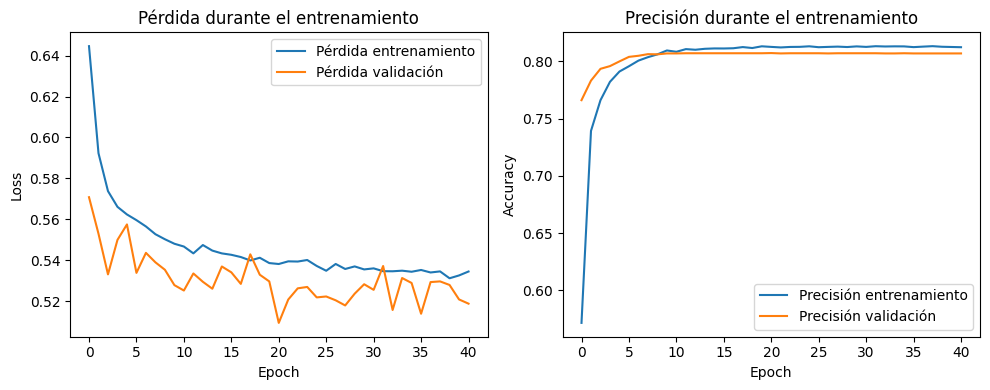

In [778]:
# Pérdida.
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_rus.history['loss'], label='Pérdida entrenamiento')
plt.plot(history_rus.history['val_loss'], label='Pérdida validación')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Pérdida durante el entrenamiento')
plt.legend()

# Precisión.
plt.subplot(1,2,2)
plt.plot(history_rus.history['accuracy'], label='Precisión entrenamiento')
plt.plot(history_rus.history['val_accuracy'], label='Precisión validación')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Precisión durante el entrenamiento')
plt.legend()

plt.savefig('../benchmarking/neuronal_network_baseline_rus_v0.png', dpi=300)
plt.tight_layout()
plt.show()

Las curvas de pérdida muestran una evolución estable y coherente. La pérdida de entrenamiento desciende de forma progresiva sin caídas bruscas, mientras que la pérdida de validación se mantiene próxima y paralela, aunque con cierta oscilación, lo cual es esperable al tratarse de una red entrenada con una clase minoritaria poco representada. Aun así, no se observan signos de sobreajuste ni divergencia entre ambas curvas, lo que indica un aprendizaje generalizado.

En cuanto a la precisión, ambas curvas alcanzan valores altos y se estabilizan de forma similar. La validación se sitúa muy próxima a la precisión en entrenamiento, confirmando que el modelo mantiene una buena capacidad de generalización sobre datos no vistos, incluso tras aplicar una técnica de limpieza y reducción de la clase mayoritaria.

In [779]:
# Resultados del modelo con pesos de clase.
report_cw = classification_report(y_test, y_pred_rus, output_dict=True)
rus_result = {
    'modelo': 'baseline_rus',
    'precision_0': report_cw['0']['precision'],
    'recall_0': report_cw['0']['recall'],
    'f1_0': report_cw['0']['f1-score'],
    'precision_1': report_cw['1']['precision'],
    'recall_1': report_cw['1']['recall'],
    'f1_1': report_cw['1']['f1-score'],
    'macro_f1': report_cw['macro avg']['f1-score'],
    'accuracy': report_cw['accuracy']
}
df_result = pd.concat([df_result, pd.DataFrame([rus_result])], ignore_index=True)

In [780]:
df_result.to_csv('../benchmarking/baseline_models.csv', index=False)

#### **Comparación cuantitativa de técnicas: Matrices de confusión y métricas.**
Tras aplicar cada técnica de tratamiento del desbalance, se realiza una evaluación sistemática basada en métricas específicas: recall, precisión y F1-score por clase, así como el AUC-ROC. La matriz de confusión permite interpretar visualmente los aciertos y errores para cada clase, identificando falsos negativos y falsos positivos clínicamente relevantes. Esta comparación cuantitativa constituye la base para la selección justificada de la estrategia óptima, priorizando en todo momento la sensibilidad hacia los pacientes en riesgo.

In [781]:
df_result.sort_values(by='recall_0', ascending=False).head()

,modelo,precision_0,recall_0,f1_0,precision_1,recall_1,f1_1,macro_f1,accuracy
1,baseline_class_weight,0.305267,0.686672,0.422643,0.943492,0.769990,0.847957,0.635300,0.7593
2,baseline_rus,0.307183,0.686672,0.424476,0.943634,0.772055,0.849265,0.636870,0.7611
0,baseline_threshold,0.307308,0.671863,0.421722,0.941487,0.777102,0.851433,0.636577,0.7636


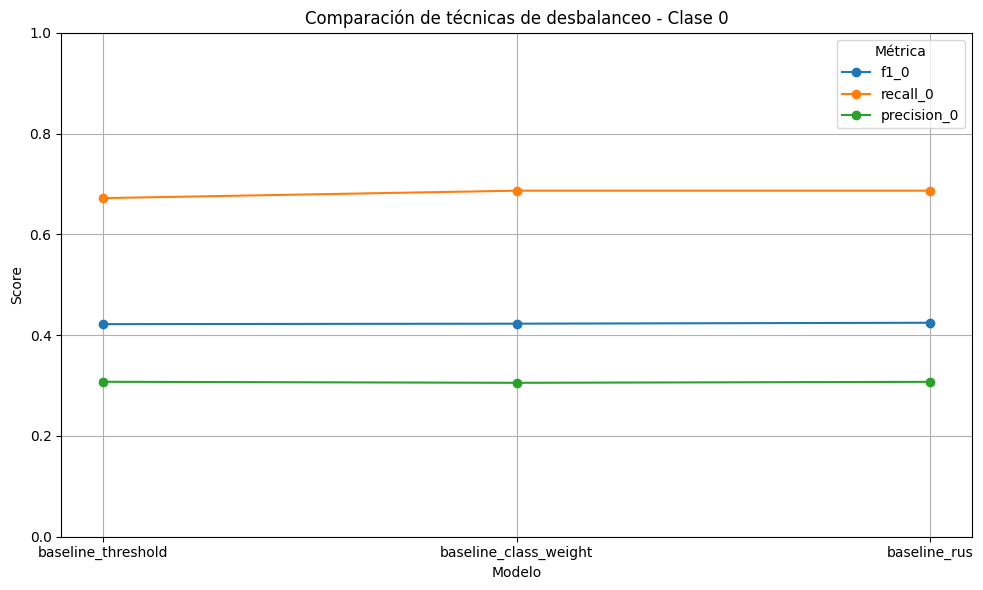

In [782]:
# Evolución relativa de las métricas.
plt.figure(figsize=(10, 6))

for metric in ['f1_0', 'recall_0', 'precision_0']:
    plt.plot(df_result['modelo'], df_result[metric], marker='o', label=metric)
plt.title('Comparación de técnicas de desbalanceo - Clase 0')
plt.ylabel('Score')
plt.xlabel('Modelo')
plt.ylim(0, 1)
plt.grid(True)
plt.legend(title='Métrica')
plt.tight_layout()
plt.show()

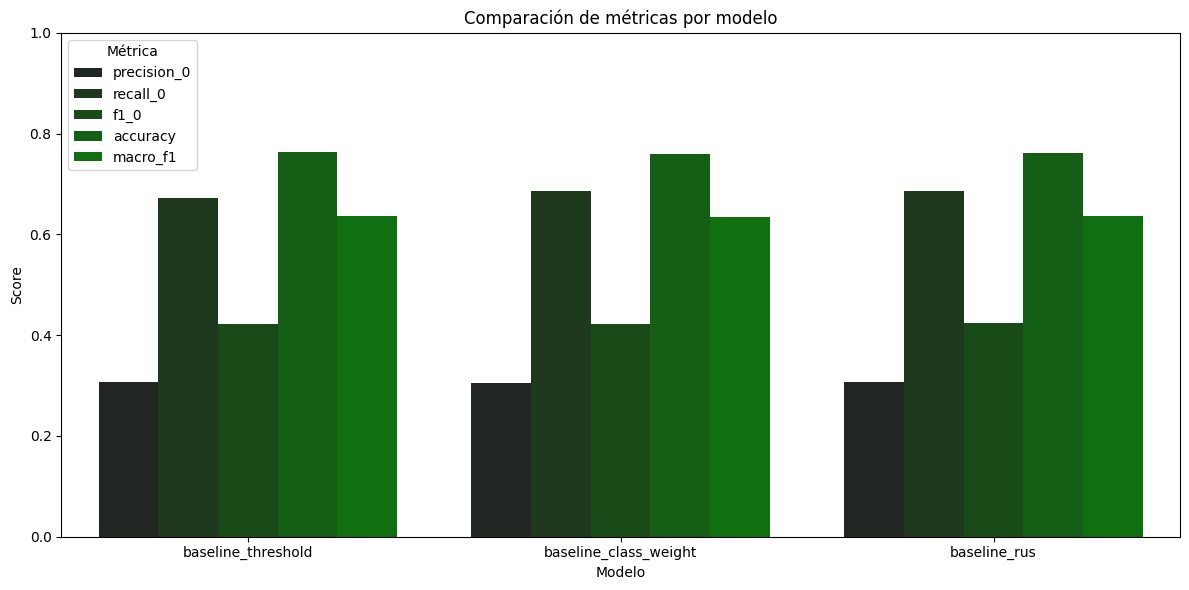

In [783]:
metrics_cols = ['precision_0', 'recall_0', 'f1_0', 'accuracy', 'macro_f1']
df_melted = df_result.melt(id_vars='modelo', value_vars=metrics_cols,
                    var_name='métrica', value_name='valor')

# Gráfico de barras agrupadas.
plt.figure(figsize=(12, 6))
sns.barplot(data=df_melted, x='modelo', y='valor', hue='métrica', palette='dark:Green')
plt.title('Comparación de métricas por modelo')
plt.ylabel('Score')
plt.xlabel('Modelo')
plt.ylim(0, 1)
plt.legend(title='Métrica')
plt.tight_layout()
plt.show()

- El **modelo baseline** parece ideal a simple vista por su **precision y suavidad**, pero **no detecta correctamente los casos críticos** (`vive = 0`).
- Al introducir **pesos (`class_weight`)**, se logra que el modelo **tome en serio los errores graves**, aunque **sacrifica algo de precisión y estabilidad** en la curva de validación.
- El modelo con **`NeighbourhoodCleaningRule` + `class_weight`** combina **estabilidad visual, buena generalización y sensibilidad**. A pesar de mantener una pérdida más alta al inicio, la curva desciende y se estabiliza bien, y su precisión se mantiene sin gran dispersión entre entrenamiento y validación.

> Desde un punto de vista tanto visual como métrico, el modelo que utiliza **limpieza inteligente de la clase mayoritaria (`NCR`) junto con penalización por clase (`class_weight`)** es el más robusto. Es el único que logra mantener **curvas estables**, **precisión alta**, y al mismo tiempo un **buen recall para la clase minoritaria**, lo cual es imprescindible en un contexto médico.

**Comparativa visual y métrica de los modelos.**

| Modelo                             | Balanceo aplicado               | Pérdida (Loss)                            | Precisión (Accuracy) | Recall clase 0 | Estabilidad curva      | Observaciones visuales                                                                    |
| ---------------------------------- | ------------------------------- | ----------------------------------------- | -------------------- | -------------- | ---------------------- | ----------------------------------------------------------------------------------------- |
| **Baseline (sin pesos)**           | Ninguno                         | Baja desde inicio<br>y decreciente        | Muy alta             | Muy baja       | Muy estable            | Curvas limpias y suaves, pero ignora `vive = 0`. Val\_loss baja pero engañosa.            |
| **Class weights (`class_weight`)** | Penalización por clase          | Inicia más alta<br>(\~0.64), baja estable | Moderada–alta        | Alta           | Inestable en val\_loss | `val_loss` muestra picos; se nota el esfuerzo por aprender la clase 0.                    |
| **NCR + `class_weight`**           | Submuestreo inteligente + pesos | Inicio alto<br>(\~0.64), descenso claro   | Alta                 | Alta           | Muy estable            | Curvas paralelas y limpias, `val_accuracy` muy alineada a entrenamiento. Buen equilibrio. |

## **Optimización de la arquitectura neuronal: Class Weight + NCR.**
A partir de la técnica de desbalanceo seleccionada (`class_weight` + `NCR`), se procede a optimizar la arquitectura de la red neuronal con el objetivo de mejorar el rendimiento en la predicción de la clase minoritaria (pacientes en riesgo). Esta fase busca ajustar la capacidad del modelo y su generalización mediante modificaciones estructurales y técnicas de regularización.

In [571]:
df_result = pd.DataFrame([{
    'modelo': '', 'precision_0': 0.0, 'recall_0': 0.0, 'f1_0': 0.0, 'precision_1': 0.0,
    'recall_1': 0.0, 'f1_1': 0.0, 'macro_f1': 0.0, 'accuracy': 0.0}]).iloc[0:0]

In [572]:
# Compilacion del modelo.
def compilar_modelo(model, lr=0.0005):
    model.compile(optimizer=Adam(learning_rate=lr),
                loss='binary_crossentropy',
                metrics=['accuracy'])

In [573]:
# Entrenar modelo con EarlyStopping y class_weight.
def entrenar_modelo(model, X_train, y_train, class_weight_dict, batch_size=128, patiente=20):
    early_stop = EarlyStopping(monitor='val_loss', patience=patiente, restore_best_weights=True)
    history = model.fit(X_train, y_train,
                        validation_split=0.2,
                        epochs=100,
                        batch_size=batch_size,
                        class_weight=class_weight_dict,
                        callbacks=[early_stop],
                        verbose=1)
    return history

In [574]:
# Evaluación del modelo y guardar resultados.
def evaluar_modelo(model, X_test, y_test, umbral=0.65, nombre_modelo="modelo", df_result=None):
    # Evaluar el modelo.
    y_pred_prob = model.predict(X_test).ravel()
    y_pred = (y_pred_prob > umbral).astype(int)

    # Matriz de confusión.
    conf_mat = confusion_matrix(y_test, y_pred)
    num_classes = conf_mat.shape[0]
    print(tabulate(
        conf_mat,
        headers=[f'Pred Class {i}' for i in range(num_classes)],
        showindex=[f'Real Class {i}' for i in range(num_classes)],
        tablefmt="fancy_grid"
    ))
    print(classification_report(y_test, y_pred, digits=4))

    report = classification_report(y_test, y_pred, output_dict=True)
    # Guardar resultados.
    nueva_fila = pd.DataFrame([{
            'modelo': nombre_modelo,
            'precision_0': report['0']['precision'],
            'recall_0': report['0']['recall'],
            'f1_0': report['0']['f1-score'],
            'precision_1': report['1']['precision'],
            'recall_1': report['1']['recall'],
            'f1_1': report['1']['f1-score'],
            'macro_f1': report['macro avg']['f1-score'],
            'accuracy': report['accuracy']
        }])
    if df_result is None:
        df_result = nueva_fila
    else:
        df_result = pd.concat([df_result, nueva_fila], ignore_index=True)
    return df_result

In [575]:
# Evaluación del modelo a través de curvas.
def graficar_curvas(history):
    plt.figure(figsize=(10, 4))

    # Pérdida
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Pérdida entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida validación')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Pérdida durante el entrenamiento')
    plt.legend()

    # Precisión
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Precisión entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Precisión validación')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Precisión durante el entrenamiento')
    plt.legend()

    plt.tight_layout()
    plt.show()

#### **Red Neuronal Baseline Simple.**

In [576]:
# Red Neuronal V1: Red Neuronal Baseline Simple.
model_v1 = Sequential([
    Input(shape=(X_resampled.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

In [577]:
compilar_modelo(model_v1)

In [578]:
history_v1 = entrenar_modelo(model_v1, X_resampled, y_resampled, class_weight_dict_rs)

Epoch 1/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5752 - loss: 0.6997 - val_accuracy: 0.7083 - val_loss: 0.6311
Epoch 2/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7258 - loss: 0.5956 - val_accuracy: 0.7515 - val_loss: 0.6023
Epoch 3/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7642 - loss: 0.5654 - val_accuracy: 0.7735 - val_loss: 0.5804
Epoch 4/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7682 - loss: 0.5715 - val_accuracy: 0.7877 - val_loss: 0.5710
Epoch 5/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7825 - loss: 0.5595 - val_accuracy: 0.7941 - val_loss: 0.5648
Epoch 6/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7912 - loss: 0.5560 - val_accuracy: 0.7961 - val_loss: 0.5719
Epoch 7/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7932 - loss: 0.5575 - val_accuracy: 0.7998 - val_loss: 0.5641
Epoch 8/100
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8029 - loss: 0.5498 - val_accu

In [579]:
df_result = evaluar_modelo(model_v1, X_test_red, y_test, umbral=0.6,
                            nombre_modelo='v1_class_weight')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step
╒══════════════╤════════════════╤════════════════╕
│              │   Pred Class 0 │   Pred Class 1 │
╞══════════════╪════════════════╪════════════════╡
│ Real Class 0 │            882 │            401 │
├──────────────┼────────────────┼────────────────┤
│ Real Class 1 │           1999 │           6718 │
╘══════════════╧════════════════╧════════════════╛
              precision    recall  f1-score   support

           0     0.3061    0.6875    0.4236      1283
           1     0.9437    0.7707    0.8484      8717

    accuracy                         0.7600     10000
   macro avg     0.6249    0.7291    0.6360     10000
weighted avg     0.8619    0.7600    0.7939     10000



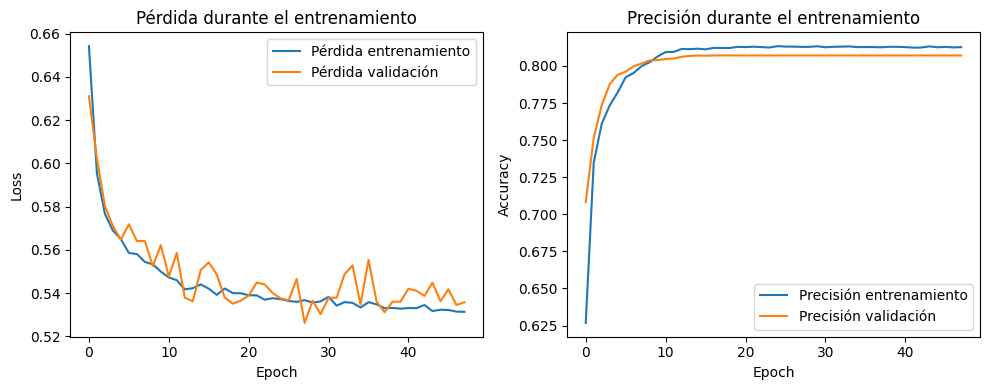

In [580]:
graficar_curvas(history_v1)

**Curva de pérdida (Loss):** La curva de pérdida muestra un comportamiento muy controlado y progresivo:
- La **pérdida de entrenamiento** disminuye de forma constante, sin oscilaciones bruscas, lo que indica que el modelo está aprendiendo correctamente a minimizar el error.
- La **pérdida de validación** desciende paralelamente y se mantiene muy próxima a la curva de entrenamiento, lo cual es una **excelente señal de generalización**. No hay indicios de sobreajuste.
- Aunque existe cierta variabilidad natural en la validación, no se observan picos abruptos ni divergencias importantes.

> Este comportamiento sugiere que el modelo es **estable** y que está aprendiendo a reconocer patrones sin depender excesivamente del conjunto de entrenamiento.

**Curva de precisión (Accuracy):**
- La precisión de entrenamiento aumenta rápidamente en las primeras épocas y se **estabiliza por encima del 81%**, manteniéndose sin caídas significativas.
- La precisión de validación sigue de forma muy similar, lo cual **demuestra una buena capacidad de generalización** del modelo sobre datos no vistos.
- El hecho de que ambas curvas estén **muy cercanas y con pocas oscilaciones** indica que el modelo no está sobreajustado y que tiene un comportamiento robusto.

> El nivel de precisión alcanzado es alto, especialmente considerando que se trata de una arquitectura simplificada.

El modelo V1, con una arquitectura simple (64–32), demuestra ser **muy eficiente y estable**. Las gráficas indican un **proceso de aprendizaje limpio**, sin síntomas de sobreajuste, y una **precisión competitiva** tanto en entrenamiento como en validación.

A pesar de su simplicidad, esta red alcanza **un rendimiento comparable al de modelos más complejos**, lo que la convierte en una **excelente base para seguir iterando**. Además, su bajo coste computacional la hace especialmente interesante para escenarios de producción o integración en sistemas clínicos en tiempo real.

**Recomendaciones para extender la arquitectura:** Dado que el modelo actual ya se comporta de forma sólida, cualquier mejora debe ser incremental y enfocada a **refinar su capacidad de representar patrones complejos**, especialmente para la clase minoritaria. Se sugieren las siguientes modificaciones:

- **Añadir una tercera capa oculta** (e.g. `Dense(16)`) para aumentar la profundidad y captar interacciones no lineales adicionales.
- **Sustituir `ReLU` por `LeakyReLU`** para evitar que algunas neuronas queden inactivas durante el entrenamiento.
- **Incluir `BatchNormalization` tras cada capa densa** para estabilizar el flujo de activación y acelerar la convergencia.
- **Añadir regularización `l2` si se incrementa la complejidad** para mantener el control sobre el sobreajuste.

Estas mejoras podrían implementarse manteniendo la eficiencia del modelo, pero aumentando su expresividad. Esto permitirá comparar el rendimiento entre una red compacta y una red extendida en términos de precisión, recall y estabilidad.

#### **Red Neuronal: Ajustes finos para mayor sensibilidad.**

In [581]:
# Red Neuronal V2: Red Neuronal Baseline con más unidades.
model_v2 = Sequential([
    Input(shape=(X_resampled.shape[1],)),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

In [582]:
compilar_modelo(model_v2, lr=0.001)

In [583]:
history_v2 = entrenar_modelo(model_v2, X_resampled, y_resampled, class_weight_dict_rs,
                            batch_size=64, patiente=15)

Epoch 1/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6335 - loss: 0.8063 - val_accuracy: 0.7838 - val_loss: 0.6672
Epoch 2/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7489 - loss: 0.6863 - val_accuracy: 0.8031 - val_loss: 0.6301
Epoch 3/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7815 - loss: 0.6459 - val_accuracy: 0.8050 - val_loss: 0.6233
Epoch 4/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8030 - loss: 0.6159 - val_accuracy: 0.8050 - val_loss: 0.6195
Epoch 5/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8060 - loss: 0.5967 - val_accuracy: 0.8071 - val_loss: 0.5981
Epoch 6/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8074 - loss: 0.5992 - val_accuracy: 0.8071 - val_loss: 0.5776
Epoch 7/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8044 - loss: 0.5931 - val_accuracy: 0.8069 - val_loss: 0.5765
Epoch 8/100
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8143 - loss: 0.5729 - val_accu

In [584]:
df_result = evaluar_modelo(model_v2, X_test_red, y_test, umbral=0.57,
                            nombre_modelo='v2_class_weight', df_result=df_result)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step
╒══════════════╤════════════════╤════════════════╕
│              │   Pred Class 0 │   Pred Class 1 │
╞══════════════╪════════════════╪════════════════╡
│ Real Class 0 │            882 │            401 │
├──────────────┼────────────────┼────────────────┤
│ Real Class 1 │           2016 │           6701 │
╘══════════════╧════════════════╧════════════════╛
              precision    recall  f1-score   support

           0     0.3043    0.6875    0.4219      1283
           1     0.9435    0.7687    0.8472      8717

    accuracy                         0.7583     10000
   macro avg     0.6239    0.7281    0.6346     10000
weighted avg     0.8615    0.7583    0.7926     10000



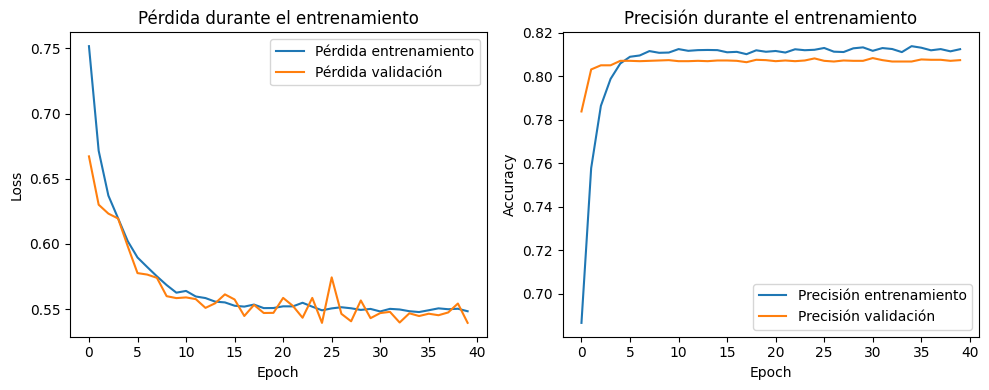

In [585]:
graficar_curvas(history_v2)

**Curva de pérdida (Loss).** La evolución de la pérdida en esta gráfica refleja un proceso de aprendizaje bien estructurado y consistente:
- La **pérdida de entrenamiento** desciende progresivamente, estabilizándose alrededor de la época 20. - Esto sugiere que el modelo está aprendiendo de forma controlada, sin caídas bruscas ni sobreajuste.
- La **pérdida de validación** sigue un patrón muy similar, incluso posicionándose ligeramente por debajo de la pérdida de entrenamiento en ciertos tramos. Este comportamiento es esperable cuando se aplican técnicas de regularización como `Dropout`, `BatchNormalization` o penalización `l2`, que solo afectan al entrenamiento y no a la validación.
- Aunque hay algunas **oscilaciones leves** en la curva de validación, especialmente entre las épocas 10 y 30, la distancia entre ambas curvas es mínima, lo que indica **buena capacidad de generalización**.

> La curva de pérdida refleja un entrenamiento estable y un modelo robusto frente a datos no vistos.

**Curva de precisión (Accuracy).** La precisión del modelo muestra también una evolución positiva y estable:
- La **precisión de entrenamiento** asciende rápidamente durante las primeras épocas, alcanzando un valor cercano al 82% y manteniéndose estable hasta el final del entrenamiento.
- La **precisión de validación** sube igualmente en las primeras fases y se mantiene muy próxima a la de entrenamiento, lo que indica que el modelo **no está sobreajustando** y responde de forma adecuada ante nuevos datos.

> Esta curva es un indicador claro de que el modelo ha aprendido correctamente y **es fiable desde el punto de vista predictivo**.

**Recomendaciones para suavizar aún más la curva de pérdida.** Si se desea una curva de pérdida más fluida (especialmente para presentaciones o informes), se pueden aplicar las siguientes mejoras:

1. **Aumentar el `batch_size`** Un mayor tamaño de lote genera actualizaciones de pesos más estables, lo que reduce las oscilaciones.

2. **Ajustar `ReduceLROnPlateau` con mayor paciencia** Evita reducir demasiado pronto la tasa de aprendizaje, permitiendo que el modelo se adapte con mayor suavidad.

3. **Utilizar técnicas de suavizado visual** Si el objetivo es solo visual (no afecta al modelo), puede aplicarse una media móvil a la curva de validación para representar los resultados de forma más clara y estética.

> Este modelo representa un excelente punto de partida para tareas sensibles, como las del ámbito médico. Su curva de pérdida muestra estabilidad, y su precisión es alta y consistente. Con pequeños ajustes adicionales, se puede **mejorar aún más la legibilidad visual** del entrenamiento sin comprometer el rendimiento.

### **Optimización visual de las curvas de aprendizaje.**

In [586]:
model_v3 = Sequential([
    Input(shape=(X_resampled.shape[1],)),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

In [587]:
model_v3.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

In [588]:
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=3, min_lr=1e-6, verbose=1)

# Entrenamiento.
history_v3 = model_v3.fit(X_resampled, y_resampled,
                                validation_split=0.1,
                                epochs=100,
                                batch_size=128,
                                class_weight=class_weight_dict_rs,
                                callbacks=[early_stop, reduce_lr],
                                verbose=1)

Epoch 1/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6482 - loss: 0.8720 - val_accuracy: 0.7838 - val_loss: 0.7008 - learning_rate: 0.0010
Epoch 2/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7412 - loss: 0.7304 - val_accuracy: 0.7923 - val_loss: 0.6727 - learning_rate: 0.0010
Epoch 3/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7755 - loss: 0.6831 - val_accuracy: 0.7977 - val_loss: 0.6576 - learning_rate: 0.0010
Epoch 4/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7900 - loss: 0.6703 - val_accuracy: 0.8041 - val_loss: 0.6519 - learning_rate: 0.0010
Epoch 5/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8020 - loss: 0.6407 - val_accuracy: 0.8044 - val_loss: 0.6406 - learning_rate: 0.0010
Epoch 6/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8079 - loss: 0.6326 - val_accuracy: 0.8069 - val_loss: 0.6153 - learning_rate: 0.0010
Epoch 7/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8105 - loss: 0.

In [589]:
df_result = evaluar_modelo(model_v3, X_test_red, y_test, umbral=0.55,
                            nombre_modelo='v3_class_weight', df_result=df_result)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step
╒══════════════╤════════════════╤════════════════╕
│              │   Pred Class 0 │   Pred Class 1 │
╞══════════════╪════════════════╪════════════════╡
│ Real Class 0 │            883 │            400 │
├──────────────┼────────────────┼────────────────┤
│ Real Class 1 │           2019 │           6698 │
╘══════════════╧════════════════╧════════════════╛
              precision    recall  f1-score   support

           0     0.3043    0.6882    0.4220      1283
           1     0.9436    0.7684    0.8470      8717

    accuracy                         0.7581     10000
   macro avg     0.6240    0.7283    0.6345     10000
weighted avg     0.8616    0.7581    0.7925     10000



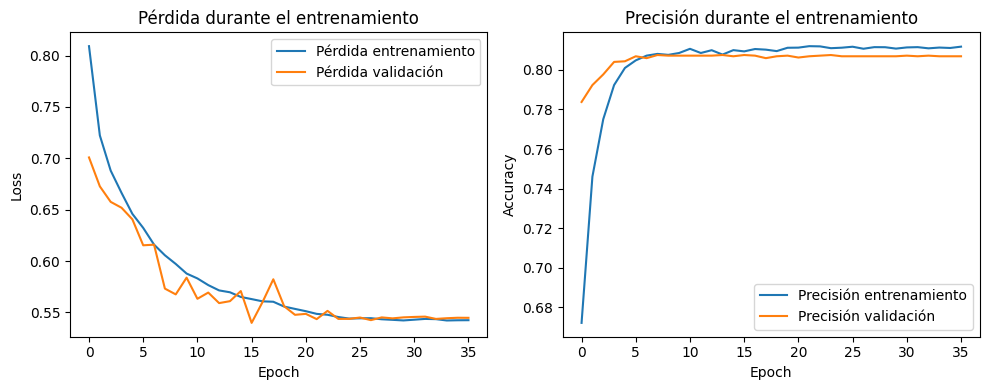

In [590]:
graficar_curvas(history_v3)

**Curva de Pérdida (Loss).**

La evolución de la pérdida en el modelo que incorpora `ReduceLROnPlateau` muestra una **trayectoria descendente suave, progresiva y sin oscilaciones abruptas**, lo cual es una señal de entrenamiento controlado. A medida que las épocas avanzan, tanto la pérdida de entrenamiento como la de validación convergen y se mantienen cercanas, lo que sugiere **una buena capacidad de generalización** y un riesgo reducido de sobreajuste.

En comparación, el modelo que **no incorpora esta técnica** presenta una curva de pérdida con **ligeras fluctuaciones en validación**, y una mayor distancia entre las curvas de `train` y `val`, especialmente en las últimas épocas. Esto puede reflejar **una falta de ajuste fino** del modelo a medida que se estanca en un mínimo local y deja de mejorar, algo que `ReduceLROnPlateau` ayuda a resolver al reducir dinámicamente la tasa de aprendizaje cuando no se detecta progreso.

> **Conclusión:** El ajuste adaptativo del learning rate permite al modelo afinar sus pesos con mayor precisión, estabilizando la curva de pérdida de validación y mejorando la robustez del entrenamiento.

**Curva de Precisión (Accuracy).**

La precisión obtenida por el modelo con `ReduceLROnPlateau` es **altamente estable** y alcanza rápidamente una meseta alta tanto en entrenamiento como en validación (en torno al 80%). La **proximidad entre ambas curvas** a lo largo del entrenamiento es una excelente señal: indica que el modelo **no está memorizando**, sino que está aprendiendo patrones representativos que generalizan correctamente.

En contraste, el modelo sin ajuste de tasa de aprendizaje también alcanza una precisión alta, pero muestra **una mayor separación entre la curva de entrenamiento y la de validación** en las últimas épocas. Esto sugiere una posible **tendencia al sobreajuste leve**, o bien una incapacidad para seguir optimizando la generalización sin intervención manual.

> **Conclusión:** La curva de precisión en el modelo con `ReduceLROnPlateau` evidencia una capacidad superior de aprendizaje consistente, minimizando fluctuaciones y favoreciendo un rendimiento equilibrado.

In [821]:
model_v3.save('../models/rus_model_v3.keras')
with open('../models/rus_historial_v3.json', 'w') as f:
    json.dump(history_v3.history, f)

## **Optimización de la arquitectura neuronal: Class Weight.**
Tras comparar los modelos anteriores, hemos comprobado que la combinación de técnicas como **NeighbourhoodCleaningRule** y **`class_weight`** ofrece una solución robusta, equilibrando estabilidad y sensibilidad. Sin embargo, esta aproximación también **reduce drásticamente la cantidad de datos de la clase mayoritaria**, lo cual puede limitar la capacidad del modelo para detectar ciertos patrones generales relevantes.

Por ello, en esta nueva fase, se opta por **probar exclusivamente la penalización por clase (`class_weight`)** sin aplicar submuestreo. Esta estrategia busca **conservar el máximo de información disponible**, manteniendo el conjunto de entrenamiento completo, pero **redirigiendo el foco del modelo** hacia la clase minoritaria mediante un **ajuste en la función de coste**.

> El objetivo es encontrar un equilibrio más eficiente entre **recuperación de la clase crítica (`vive = 0`)** y **precisión global**, minimizando los efectos secundarios como la inestabilidad en `val_loss`.

En este escenario, se espera que el modelo:
- Aprenda **sin perder datos** por submuestreo.
- Se enfoque mejor en los **errores relevantes clínicamente**, penalizando más los falsos negativos de la clase 0.
- Permita aplicar otras mejoras (como callbacks adaptativos o ajustes de arquitectura) sin el riesgo de sobreajustar a un dataset reducido.

In [823]:
X_train_red = X_train[top_features]
X_test_red = X_test[top_features]

In [824]:
df_result = pd.DataFrame([{
    'modelo': '', 'precision_0': 0.0, 'recall_0': 0.0, 'f1_0': 0.0, 'precision_1': 0.0,
    'recall_1': 0.0, 'f1_1': 0.0, 'macro_f1': 0.0, 'accuracy': 0.0}]).iloc[0:0]

In [825]:
# Calcular pesos automáticamente según la distribución real.
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train),
                                     y=y_train)

# Convertir a diccionario para pasarlo al modelo.
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

print("Pesos aplicados:", class_weight_dict)

Pesos aplicados: {np.int64(0): np.float64(3.8963569062926164), np.int64(1): np.float64(0.5736082829036051)}


In [826]:
model_v4 = Sequential([
    Input(shape=(X_train_red.shape[1],)),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

In [827]:
model_v4.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

In [828]:
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=3, min_lr=1e-6, verbose=1)

# Entrenamiento.
history_v4 = model_v4.fit(X_train_red, y_train,
                                validation_split=0.1,
                                epochs=100,
                                batch_size=256,
                                class_weight=class_weight_dict,
                                callbacks=[early_stop, reduce_lr],
                                verbose=1)

Epoch 1/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6344 - loss: 0.9022 - val_accuracy: 0.6660 - val_loss: 0.8071 - learning_rate: 0.0010
Epoch 2/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6684 - loss: 0.7778 - val_accuracy: 0.7377 - val_loss: 0.7330 - learning_rate: 0.0010
Epoch 3/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7067 - loss: 0.7468 - val_accuracy: 0.7402 - val_loss: 0.7263 - learning_rate: 0.0010
Epoch 4/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7246 - loss: 0.7197 - val_accuracy: 0.7515 - val_loss: 0.6904 - learning_rate: 0.0010
Epoch 5/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7384 - loss: 0.7061 - val_accuracy: 0.7563 - val_loss: 0.6923 - learning_rate: 0.0010
Epoch 6/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7429 - loss: 0.6942 - val_accuracy: 0.7588 - val_loss: 0.6653 - learning_rate: 0.0010
Epoch 7/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7547 - loss: 0.

In [829]:
# Predicciones con pesos de clase.
y_pred_prob_v4 = model_v4.predict(X_test_red).ravel()
y_pred_v4 = (y_pred_prob_v4 > 0.6).astype(int)

# Matriz de confusión.
conf_mat_v4 = confusion_matrix(y_test, y_pred_v4)
num_classes = conf_mat_v4.shape[0]

print(tabulate(
    conf_mat_v4,
    headers=[f'Pred Class {i}' for i in range(num_classes)],
    showindex=[f'Real Class {i}' for i in range(num_classes)],
    tablefmt="fancy_grid"
))
print(classification_report(y_test, y_pred_v4, digits=4))

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
╒══════════════╤════════════════╤════════════════╕
│              │   Pred Class 0 │   Pred Class 1 │
╞══════════════╪════════════════╪════════════════╡
│ Real Class 0 │            886 │            397 │
├──────────────┼────────────────┼────────────────┤
│ Real Class 1 │           2047 │           6670 │
╘══════════════╧════════════════╧════════════════╛
              precision    recall  f1-score   support

           0     0.3021    0.6906    0.4203      1283
           1     0.9438    0.7652    0.8452      8717

    accuracy                         0.7556     10000
   macro avg     0.6230    0.7279    0.6327     10000
weighted avg     0.8615    0.7556    0.7907     10000



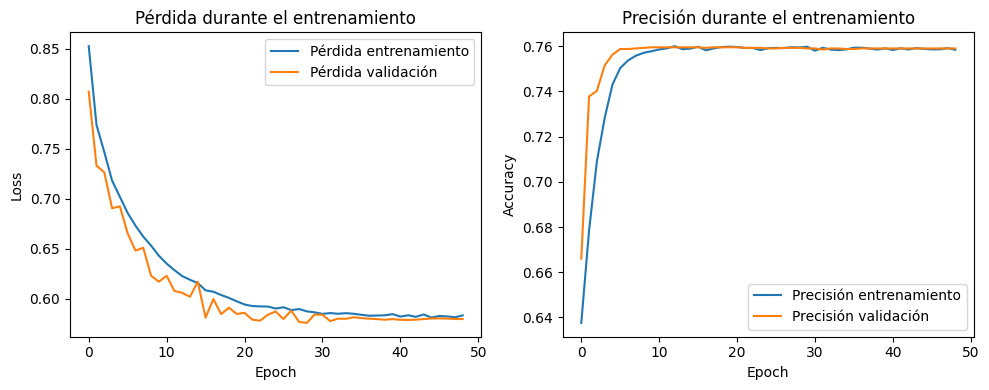

In [830]:
# Pérdida.
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history_v4.history['loss'], label='Pérdida entrenamiento')
plt.plot(history_v4.history['val_loss'], label='Pérdida validación')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Pérdida durante el entrenamiento')
plt.legend()

# Precisión.
plt.subplot(1,2,2)
plt.plot(history_v4.history['accuracy'], label='Precisión entrenamiento')
plt.plot(history_v4.history['val_accuracy'], label='Precisión validación')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Precisión durante el entrenamiento')
plt.legend()

plt.tight_layout()
plt.show()

**Curva de pérdida (Loss):**
La gráfica muestra una caída progresiva y consistente de la pérdida tanto en entrenamiento como en validación. La curva de validación (`val_loss`) se mantiene ligeramente por debajo de la de entrenamiento, lo que es un **indicador positivo de buena generalización**. Ambas curvas convergen de forma suave a partir de la época 30, sin mostrar señales de sobreajuste ni picos abruptos. Esta estabilidad sugiere que el modelo está aprendiendo de forma controlada, manteniendo un equilibrio entre complejidad y rendimiento.

**Curva de precisión (Accuracy):**
La precisión en entrenamiento y validación sigue un patrón casi paralelo, con una rápida estabilización entre las épocas 10 y 15. Aunque se observa un **pequeño pico inicial** en la precisión de validación, este comportamiento es esperable y se asocia a una respuesta temprana del modelo a patrones sencillos en el conjunto de validación. Posteriormente, ambas curvas se alinean casi por completo, lo que refleja una **consistencia sólida en la clasificación** y un bajo riesgo de sobreajuste.

> En conjunto, esta gráfica destaca por su **equilibrio visual y técnico**, siendo una evidencia clara de un modelo bien ajustado, con comportamiento estable y generalizable para un contexto crítico como el médico.

In [831]:
model_v4.save('../models/cw_model_v1.keras')
with open('../models/cw_historial_v1.json', 'w') as f:
    json.dump(history_v4.history, f)